In [ ]:
import black
import jupyter_black

jupyter_black.load(
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY313,
)

## Solution to Exercise 6.2

[Schummer *et al.*](https://doi.org/10.1016/S0378-1119(99)00342-X) used microarray technology to analyze the expression of 1536 genes in ovarian cancer and non-cancer tissues. Their primary objective was to identify differentially expressed genes in ovarian cancer versus non-cancer tissues to discover genes with diagnosis potential.

The data file [`ovo.csv`](ovo.csv) contains numerical gene expressions (for 1536 genes) for 54 tissue samples. Each column corresponds to a specific gene, named `X.1`, `X.2`, and so on. Each tissue sample has been classified as non-cancer (`N`) or cancer (`C`) tissue, and these labels can be found in the column `class`. The raw data has been preprocessed by centring each gene expression so that no further preprocessing is needed. The raw data can be loaded as follows:

In [1]:
"""Load the data set."""

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline
sns.set_theme(style="ticks", context="notebook", palette="colorblind")

data_ovo = pd.read_csv("ovo.csv")
classes = data_ovo["class"]  # Classification of samples.
# Turn the class labels into numbers for numeric methods
y_ovo = [1 if i == "C" else 0 for i in classes]
X_ovo = data_ovo.filter(like="X.", axis=1)  # Gene expressions for samples.

### 6.2(a)

**Task: Explore the raw data. Do you find genes that appear to show significant differences in expression between non-cancer and cancer tissue?**

**Hint:** You can, for instance, inspect the raw data by running a principal component analysis.

In [2]:
from sklearn.decomposition import PCA

pca = PCA()
scores = pca.fit_transform(X_ovo)

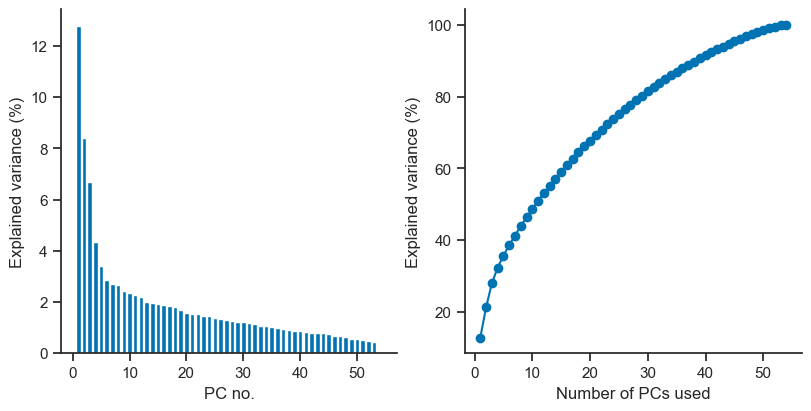

In [3]:
fig, (ax1, ax2) = plt.subplots(
    constrained_layout=True, ncols=2, figsize=(8, 4)
)
comp = range(1, len(pca.explained_variance_ratio_) + 1)
ax1.bar(comp, 100 * pca.explained_variance_ratio_)
ax2.plot(comp, 100 * np.cumsum(pca.explained_variance_ratio_), marker="o")
ax1.set(xlabel="PC no.", ylabel="Explained variance (%)")
ax2.set(xlabel="Number of PCs used", ylabel="Explained variance (%)")
sns.despine(fig=fig)

The explained variance indicates that a substantial number of principal components are required to capture a significant portion of the variance in the data. However, the scores of the first few principal components show interesting patterns:

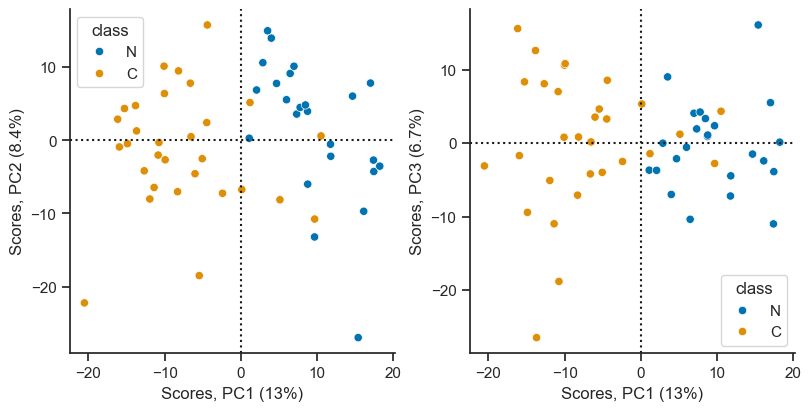

In [4]:
fig, axes = plt.subplots(constrained_layout=True, ncols=2, figsize=(8, 4))

sns.scatterplot(
    data=data_ovo, x=scores[:, 0], y=scores[:, 1], hue="class", ax=axes[0]
)

sns.scatterplot(
    data=data_ovo, x=scores[:, 0], y=scores[:, 2], hue="class", ax=axes[1]
)
percent = pca.explained_variance_ratio_ * 100

axes[0].set(
    xlabel=f"Scores, PC1 ({percent[0]:.2g}%)",
    ylabel=f"Scores, PC2 ({percent[1]:.2g}%)",
)


axes[1].set(
    xlabel=f"Scores, PC1 ({percent[0]:.2g}%)",
    ylabel=f"Scores, PC3 ({percent[2]:.2g}%)",
)


for ax in axes:
    ax.axhline(y=0, ls=":", color="k")
    ax.axvline(x=0, ls=":", color="k")

sns.despine(fig=fig)

The PC1 scores separate the two tissue types. To understand what variables are important for this separation, we inspect the loadings:

10 largest along PC1: [1124 1306 1525  364 1159  692   92 1116  538 1490]


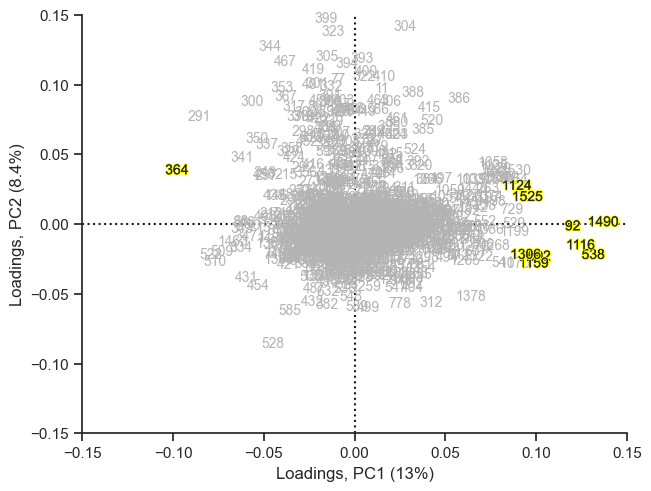

In [5]:
import matplotlib.patheffects as pe


loadings = pca.components_
pc1_loadings = loadings[0, :]
pc2_loadings = loadings[1, :]
percent = pca.explained_variance_ratio_ * 100


fig, ax = plt.subplots(constrained_layout=True)

ax.set(
    xlabel=f"Loadings, PC1 ({percent[0]:.2g}%)",
    ylabel=f"Loadings, PC2 ({percent[1]:.2g}%)",
)
ax.axhline(y=0, ls=":", color="k")
ax.axvline(x=0, ls=":", color="k")

# Get the 10 largest loadings along PC1 for highlighting:
highlighted_indices = np.argsort(abs(pc1_loadings))[-10:]
print(f"10 largest along PC1: {highlighted_indices}")

for i, (xi, yi) in enumerate(zip(pc1_loadings, pc2_loadings)):
    if i in highlighted_indices:
        txt = ax.text(xi, yi, i, fontsize="small", ha="center", va="center")
        txt.set_path_effects(
            [
                pe.withStroke(linewidth=1.5, foreground="yellow"),
                pe.Normal(),
            ]
        )
    else:
        txt = ax.text(
            xi, yi, i, fontsize="small", ha="center", va="center", color="0.7"
        )


ax.set_xlim(-0.15, 0.15)
ax.set_ylim(-0.15, 0.15)
sns.despine(fig=fig)

Finally, we create a scatterplot to show how two genes with high loadings (for PC1) separate the tissue samples:

Text(34.875, 0.5, 'Gene expression for 92')

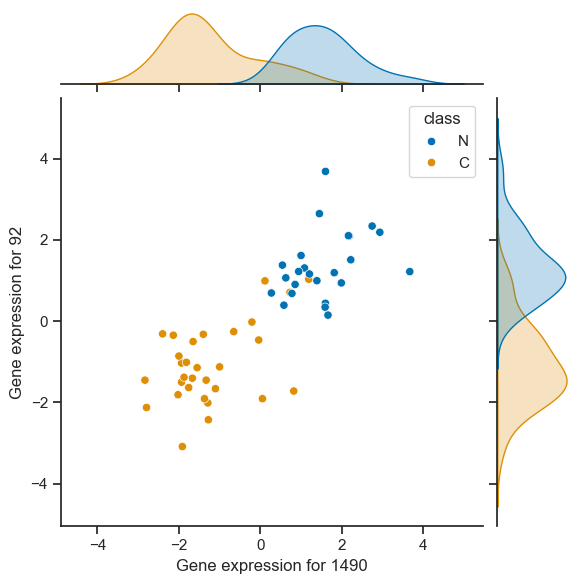

In [6]:
gene1 = 1490
gene2 = 92
grid = sns.jointplot(
    data=data_ovo,
    x=f"X.{gene1 + 1}",
    y=f"X.{gene2 + 1}",
    hue="class",
)
ax = grid.fig.axes[0]
ax.set_xlabel(f"Gene expression for {gene1}")
ax.set_ylabel(f"Gene expression for {gene2}")

#### Your answer to question 6.2(a): Did you find any promising genes?
Yes, genes with the highest absolute loadings on Principal Component 1 (PC1) appear promising for distinguishing between the samples. For example 1490 and 92 as shown above.

### 6.2(b)

**Task: In the following task, you will develop a classifier to predict whether a tissue sample is cancerous or non-cancerous based on gene expression data. Which error type (false positive or false negative) should be minimised?**

#### Your answer to question 6.2(b): Will you minimise false positives or negatives?

While a false positive could result in unnecessary and potentially invasive medical procedures, a false negative may be a greater risk by delaying treatment. Assuming that starting medical treatment is not only based on our classifier and that secondary testing will be used, then a false positive made by our classifier would be identified in subsequent tests. Therefore, to minimise the risk of overlooking cancerous samples and delaying treatment, we prioritise the minimisation of false negatives.

### 6.2(c)

**Task: Create a decision tree classifier to classify tissue type from the gene expressions. Optimize the tree depth using cross-validation on a training set. Report the optimal maximum depth of the resulting tree.**

With reference to the previous problem:

* If you prioritised minimising false positives, use the `precision` as your optimisation metric.
* If you prioritised minimising false negatives, use the `recall` as your optimisation metric.
* If you opted for a balanced approach, use the `balanced_accuracy` as your optimisation metric.


**Hint:**

1. The optimisation of the decision tree can be done as follows (assuming that you have already split into the training and test sets):

```python
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Set up a grid search:
parameters = {"max_depth": range(1, 10)}
grid = GridSearchCV(
    DecisionTreeClassifier(),
    parameters,
    scoring="recall",  # Swap this with the metric you prefer
)
# Run the grid search:
grid.fit(X_train, y_train)

# Get the best classifier from the grid search:
best_tree = grid.best_estimator_
print("Best tree:", best_tree)
print("Best score", grid.best_score_)
print("Best parameters", grid.best_params_)
```

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_ovo, y_ovo, stratify=classes, test_size=0.33, random_state=2025
)

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [18]:
parameters = {"max_depth": range(1, 10)}
grid = GridSearchCV(
    DecisionTreeClassifier(random_state=2025),
    parameters,
    scoring="recall",  # Use recall to minimize false negatives
)
# Run the grid search:
grid.fit(X_train, y_train)

# Get the best classifier from the grid search:
best_tree = grid.best_estimator_
print("Best tree:", best_tree)
print("Best score", grid.best_score_)
print("Best parameters", grid.best_params_)

Best tree: DecisionTreeClassifier(max_depth=2, random_state=2025)
Best score 0.9
Best parameters {'max_depth': 2}


#### Your answer to question 6.2(c): What depth did you get for your tree?
The optimal depth was 2.

### 6.2(d)

**Task: Create a k-nearest neighbours classifier to classify tissue type from the gene expressions. Optimize the number of neighbours using cross-validation on a training set. Report the optimal number of neighbours.**

**Hint:**

1. The optimisation of the k-nearest neighbours classifier can be done as follows (assuming that you have already split into the training and test sets):

```python
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Set up a grid search:
parameters = {"n_neighbors": range(1, 15)}
grid = GridSearchCV(
    KNeighborsClassifier(),
    parameters,
    scoring="recall",  # Swap this with the metric you prefer
)
# Run the grid search:
grid.fit(X_train, y_train)

# Get the best classifier from the grid search:
best_knn = grid.best_estimator_
print("Best knn:", best_knn)
print("Best score", grid.best_score_)
print("Best parameters", grid.best_params_)
```

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Set up a grid search:
parameters = {"n_neighbors": range(1, 15)}
grid = GridSearchCV(
    KNeighborsClassifier(),
    parameters,
    scoring="recall",  # To minimize false negatives
)
# Run the grid search:
grid.fit(X_train, y_train)

# Get the best classifier from the grid search:
best_knn = grid.best_estimator_
print("Best knn:", best_knn)
print("Best score", grid.best_score_)
print("Best parameters", grid.best_params_)

Best knn: KNeighborsClassifier(n_neighbors=11)
Best score 0.85
Best parameters {'n_neighbors': 11}


#### Your answer to question 6.2(d): What was the optimal number of neighbours?
The optimal number of neighbours was 11.

### 6.2(e)

**Task: Create a random forest classifier to classify tissue type from the gene expressions. Optimize the number of trees and levels using cross-validation on a training set. Report the optimal number of trees and levels.**

**Hint:**

1. The optimisation of the random forest classifier can be done as follows (assuming that you have already split into the training and test sets):

```python
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Set up a grid search:
parameters = {
    "n_estimators": [10, 50, 100, 200, 500],  # the number of trees
    "max_depth": range(1, 11),  # the maximum depth
}
grid = GridSearchCV(
    RandomForestClassifier(),
    parameters,
    scoring="recall",  # Swap this with the metric you prefer
    verbose=2,  # Print out text to show the progress of the fitting
)
# Run the grid search:
grid.fit(X_train, y_train)

# Get the best classifier from the grid search:
best_forest = grid.best_estimator_
print("Best forest:", best_forest)
print("Best score", grid.best_score_)
print("Best parameters", grid.best_params_)
```

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Set up a grid search:
parameters = {
    "n_estimators": [10, 50, 100, 500],  # the number of trees
    "max_depth": range(1, 10),  # the maximum depth
}
grid = GridSearchCV(
    RandomForestClassifier(random_state=2025),
    parameters,
    scoring="recall",  # Swap this with the metric you prefer
    verbose=2,  # Print out text to show the progress of the fitting
)
# Run the grid search:
grid.fit(X_train, y_train)

# Get the best classifier from the grid search:
best_forest = grid.best_estimator_
print("Best forest:", best_forest)
print("Best score", grid.best_score_)
print("Best parameters", grid.best_params_)

#### Your answer to question 6.2(e): What was the optimal number of estimators and tree depth?
The optimal number of estimators was 50 and the depth was 1.

### 6.2(f)

**Task: Compare the three optimised classifiers you have made by applying them to the test set and obtaining the corresponding confusion matrices. Also compute the [precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html), [recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html), and the [balanced accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) for the test set. Which classifier performs best?**



**Hint:** The metrics can be computed as follows:
```python
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import (
    recall_score,
    precision_score,
    balanced_accuracy_score,
)

y_hat = best_tree.predict(X_test)
recall_tree = recall_score(y_test, y_hat)
precision_tree = precision_score(y_test, y_hat)
bac_tree = balanced_accuracy_score(y_test, y_hat)
print(f"Recall: {recall_tree:.3f}")
print(f"Precision: {precision_tree:.3f}")
print(f"Balanced accuracy: {bac_tree:.3f}")

ConfusionMatrixDisplay.from_estimator(
    best_tree,
    X_test,
    y_test,
    colorbar=True,
)
```

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import (
    recall_score,
    precision_score,
    balanced_accuracy_score,
)

fig, axes = plt.subplots(constrained_layout=True, ncols=3, figsize=(9, 3))

axes[0].set_title("Decision tree (test)")
ConfusionMatrixDisplay.from_estimator(
    best_tree,
    X_test,
    y_test,
    colorbar=False,
    ax=axes[0],
)
fig.colorbar(axes[0].images[0], ax=axes[0], shrink=0.7)

axes[1].set_title("kNN (test)")
ConfusionMatrixDisplay.from_estimator(
    best_knn, X_test, y_test, colorbar=False, ax=axes[1]
)
fig.colorbar(axes[1].images[0], ax=axes[1], shrink=0.7)

axes[2].set_title("Random forest (test)")
ConfusionMatrixDisplay.from_estimator(
    best_forest, X_test, y_test, colorbar=False, ax=axes[2]
)
fig.colorbar(axes[2].images[0], ax=axes[2], shrink=0.7)

In [ ]:
table = {
    "Classifier": [],
    "Recall (test)": [],
    "Precision (test)": [],
    "Balanced accuracy (test)": [],
}
for cls in (best_tree, best_knn, best_forest):
    name = str(cls)
    print(name)
    y_hat = cls.predict(X_test)
    recall = recall_score(y_test, y_hat)
    precision = precision_score(y_test, y_hat)
    bac = balanced_accuracy_score(y_test, y_hat)
    table["Classifier"].append(name)
    table["Recall (test)"].append(recall)
    table["Precision (test)"].append(precision)
    table["Balanced accuracy (test)"].append(bac)
    print(f"\t-Recall: {recall:.3f}")
    print(f"\t-Precision: {precision:.3f}")
    print(f"\t-Balanced accuracy: {bac:.3f}")
table = pd.DataFrame(table)
table.sort_values(by="Recall (test)", ascending=False)

#### Your answer to question 6.2(f): Which classifier performs best?
From these results, we see that the random forest classifier makes fewer false negative mistakes (resulting in a higher recall). However, it produces one additional false positive compared to the k-nearest neighbours classifier (resulting in a lower precision). Since we focus on minimizing the number of false negatives (as per our answer to 6.2(b)), the random forest classifier performs best.